In [2]:
import findspark
findspark.init()

In [3]:
from pyspark import SparkConf, SparkContext

In [4]:
conf=SparkConf().setAppName("BDProject").setMaster("local[4]")

In [5]:
sc=SparkContext(conf=conf)

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import col
from pyspark.sql.functions import year, month
from pyspark.sql.types import IntegerType, StringType, DateType

In [7]:
spark = SparkSession.builder \
    .appName('ss') \
    .master('local[4]') \
    .getOrCreate()

Importujemy rozpakowane dane tekstowe

In [8]:
pathUsers="travelData\\Users.xml"

In [9]:
rawUsers=sc.textFile(pathUsers)

In [10]:
rawUsers.filter(lambda x: x.startswith('  <row Id=')).count()

51525

In [11]:
rawUsers.take(4)

['<?xml version="1.0" encoding="utf-8"?>',
 '<users>',
 '  <row Id="-1" Reputation="1" CreationDate="2011-06-21T15:16:44.253" DisplayName="Community" LastAccessDate="2011-06-21T15:16:44.253" WebsiteUrl="http://meta.stackexchange.com/" Location="on the server farm" AboutMe="&lt;p&gt;Hi, I\'m not really a person.&lt;/p&gt;&#xA;&#xA;&lt;p&gt;I\'m a background process that helps keep this site clean!&lt;/p&gt;&#xA;&#xA;&lt;p&gt;I do things like&lt;/p&gt;&#xA;&#xA;&lt;ul&gt;&#xA;&lt;li&gt;Randomly poke old unanswered questions every hour so they get some attention&lt;/li&gt;&#xA;&lt;li&gt;Own community questions and answers so nobody gets unnecessary reputation from them&lt;/li&gt;&#xA;&lt;li&gt;Own downvotes on spam/evil posts that get permanently deleted&lt;/li&gt;&#xA;&lt;li&gt;Own suggested edits from anonymous users&lt;/li&gt;&#xA;&lt;li&gt;&lt;a href=&quot;http://meta.stackexchange.com/a/92006&quot;&gt;Remove abandoned questions&lt;/a&gt;&lt;/li&gt;&#xA;&lt;/ul&gt;&#xA;" Views="0" UpV

Tworzymy funkcję czyszczącą RDDs

In [12]:
def rddToDf(RDDIn):
    def preCleanUp(RDDIn):
        def cleaning(listIn):
            listOut=[]
            for x in listIn:
                if listIn.index(x)%2==0:
                    listOut.append(x.replace(' ','').replace('<','').replace('=',''))
                else:
                    listOut.append(x)
            return {listOut[i]:listOut[i+1] for i in range(0,len(listOut)-1,2)}
        def casting(dictIn):
            '''formatujemy datę i tekst'''
            def textMining(string):
                import re
                listXmlChar={'&lt;':'', '&amp':'&','&gt;':'','&quot;':'"','&apos;':'\'','&#xA;':''}
                y=re.sub('&lt;.*?&gt;','',string)
                for x in listXmlChar.keys():
                    z=y.replace(x,listXmlChar[x])
                    y=z
                return z
            from datetime import datetime
            for x in dictIn.keys():
                if x.find('Date')>0:
                    dictIn[x]=datetime.strptime(dictIn[x][0:-4],'%Y-%m-%dT%H:%M:%S')
                else:
                    dictIn[x]=textMining(dictIn[x])
            return dictIn
        return RDDIn.filter(lambda x: x.startswith('  <row Id=')).map(lambda x: x.split('"')).map(cleaning).map(casting)
    dictRDD=preCleanUp(RDDIn)
    listOfColums=dictRDD.flatMap(lambda x: list(x.keys())).distinct().collect()
    def newDict(dictIn):
        for col in listOfColums:
            if col not in dictIn.keys():
                dictIn[col]=None
        return dictIn
    return dictRDD.map(newDict)#.map(lambda x: Row(**x)).toDF(sampleRatio=100)

In [13]:
usersRDD=rddToDf(rawUsers)

In [14]:
usersDF=usersRDD.map(lambda x: Row(**x)).toDF(sampleRatio=100)

In [15]:
usersDF.printSchema()

root
 |-- AboutMe: string (nullable = true)
 |-- AccountId: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- CreationDate: timestamp (nullable = true)
 |-- DisplayName: string (nullable = true)
 |-- DownVotes: string (nullable = true)
 |-- LastAccessDate: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- ProfileImageUrl: string (nullable = true)
 |-- Reputation: string (nullable = true)
 |-- UpVotes: string (nullable = true)
 |-- Views: string (nullable = true)
 |-- WebsiteUrl: string (nullable = true)
 |-- rowId: string (nullable = true)



In [32]:
usersDF.select('AboutMe', 'DisplayName').where(usersDF.Age.isNull()).count()

39075

In [16]:
usersDF.withColumn('AgeInt',usersDF.Age.cast("integer")).select("AgeInt").describe().show()

+-------+-----------------+
|summary|           AgeInt|
+-------+-----------------+
|  count|            12450|
|   mean|33.51694779116466|
| stddev|9.670550847825702|
|    min|               13|
|    max|              148|
+-------+-----------------+



In [16]:
listXmlChar={'&lt;':'<', '&amp':'&','&gt;':'>','&quot;':'"','&apos;':'\''}

In [33]:
usersDF.select('Age').describe().show()

+-------+-----------------+
|summary|              Age|
+-------+-----------------+
|  count|            12450|
|   mean|33.51694779116466|
| stddev|9.670550847825702|
|    min|              100|
|    max|               98|
+-------+-----------------+



In [34]:
usersDF.withColumn('AgeInt',usersDF.Age.cast("integer")).\
groupBy('AgeInt').count().orderBy('AgeInt',ascending=True).show(5)

+------+-----+
|AgeInt|count|
+------+-----+
|  null|39075|
|    13|    1|
|    14|    2|
|    15|    8|
|    16|   13|
+------+-----+
only showing top 5 rows



In [ ]:
dataAge=usersDF.where(usersDF.Age.isNotNull()).\
withColumn('AgeInt',usersDF.Age.cast("integer")).select('AgeInt').collect()

In [ ]:
plt.hist(dataAge,bins=10)
plt.show()

In [78]:
usersDFPeriod=usersDF.withColumn('period',year(usersDF.CreationDate)*100+month(usersDF.CreationDate))\
.groupBy('period').count()\
.orderBy('period',ascending=True)

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [73]:
inputX=usersDFPeriod.select('period').collect()
inputY=usersDFPeriod.select('count').collect()

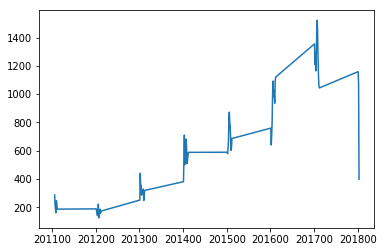

In [74]:
plt.plot(inputX,inputY)
plt.show()

In [113]:
usersRDD.take(1)

[{'AboutMe': "Hi, I'm not really a person.I'm a background process that helps keep this site clean!I do things likeRandomly poke old unanswered questions every hour so they get some attentionOwn community questions and answers so nobody gets unnecessary reputation from themOwn downvotes on spam/evil posts that get permanently deletedOwn suggested edits from anonymous usersRemove abandoned questions",
  'AccountId': '-1',
  'Age': None,
  'CreationDate': datetime.datetime(2011, 6, 21, 15, 16, 44),
  'DisplayName': 'Community',
  'DownVotes': '14237',
  'LastAccessDate': datetime.datetime(2011, 6, 21, 15, 16, 44),
  'Location': 'on the server farm',
  'ProfileImageUrl': None,
  'Reputation': '1',
  'UpVotes': '3147',
  'Views': '0',
  'WebsiteUrl': 'http://meta.stackexchange.com/',
  'rowId': '-1'}]

In [114]:
import re
textOnly=usersRDD.map(lambda x: x['AboutMe']).filter(lambda x: x!=None).\
flatMap(lambda x: re.split(r'\W+',x))

In [125]:
textOnly.filter(lambda x: len(x)>3).map(lambda x: (x,1))\
.reduceByKey(lambda x,y: x+y).takeOrdered(10, (lambda x: -x[1]))

[('with', 4081),
 ('developer', 2195),
 ('have', 2007),
 ('that', 1992),
 ('software', 1528),
 ('from', 1429),
 ('working', 1326),
 ('like', 1273),
 ('about', 1271),
 ('Software', 1209)]

In [116]:
pathPosts="travelData\Posts.xml"

In [117]:
rawPosts=sc.textFile(pathPosts)

In [118]:
rawPosts.take(3)

['<?xml version="1.0" encoding="utf-8"?>',
 '<posts>',
 '  <row Id="1" PostTypeId="1" AcceptedAnswerId="393" CreationDate="2011-06-21T20:19:34.730" Score="8" ViewCount="435" Body="&lt;p&gt;My fiancée and I are looking for a good Caribbean cruise in October and were wondering which islands are best to see and which Cruise line to take?&lt;/p&gt;&#xA;&#xA;&lt;p&gt;It seems like a lot of the cruises don\'t run in this month due to Hurricane season so I\'m looking for other good options.&lt;/p&gt;&#xA;&#xA;&lt;p&gt;&lt;strong&gt;EDIT&lt;/strong&gt; We\'ll be travelling in 2012.&lt;/p&gt;&#xA;" OwnerUserId="9" LastEditorUserId="101" LastEditDate="2011-12-28T21:36:43.910" LastActivityDate="2012-05-24T14:52:14.760" Title="What are some Caribbean cruises for October?" Tags="&lt;caribbean&gt;&lt;cruising&gt;&lt;vacations&gt;" AnswerCount="4" CommentCount="4" ClosedDate="2013-02-25T23:52:47.953" />']

In [119]:
postsRDD=rddToDf(rawPosts)

In [120]:
postsRDD.take(1)

[{'AcceptedAnswerId': '393',
  'AnswerCount': '4',
  'Body': "My fiancée and I are looking for a good Caribbean cruise in October and were wondering which islands are best to see and which Cruise line to take?It seems like a lot of the cruises don't run in this month due to Hurricane season so I'm looking for other good options.EDIT We'll be travelling in 2012.",
  'ClosedDate': datetime.datetime(2013, 2, 25, 23, 52, 47),
  'CommentCount': '4',
  'CommunityOwnedDate': None,
  'CreationDate': datetime.datetime(2011, 6, 21, 20, 19, 34),
  'FavoriteCount': None,
  'LastActivityDate': datetime.datetime(2012, 5, 24, 14, 52, 14),
  'LastEditDate': datetime.datetime(2011, 12, 28, 21, 36, 43),
  'LastEditorDisplayName': None,
  'LastEditorUserId': '101',
  'OwnerDisplayName': None,
  'OwnerUserId': '9',
  'ParentId': None,
  'PostTypeId': '1',
  'Score': '8',
  'Tags': '',
  'Title': 'What are some Caribbean cruises for October?',
  'ViewCount': '435',
  'rowId': '1'}]

In [121]:
postsTitleOnly=postsRDD.map(lambda x: x['Title']).filter(lambda x: x!=None).\
flatMap(lambda x: re.split(r'\W+',x)).map(lambda x: x.lower())

In [124]:
postsTitleOnly.filter(lambda x: len(x)>3).map(lambda x: (x,1))\
.reduceByKey(lambda x,y: x+y).takeOrdered(30, (lambda x: -x[1]))

[('visa', 7269),
 ('from', 3712),
 ('with', 2923),
 ('what', 2789),
 ('travel', 2088),
 ('schengen', 1961),
 ('airport', 1676),
 ('passport', 1666),
 ('need', 1462),
 ('flight', 1396),
 ('transit', 1324),
 ('when', 1314),
 ('there', 1312),
 ('does', 1119),
 ('have', 1110),
 ('where', 970),
 ('visit', 858),
 ('citizen', 842),
 ('travelling', 752),
 ('tourist', 740),
 ('after', 736),
 ('ticket', 732),
 ('will', 688),
 ('time', 688),
 ('country', 685),
 ('without', 680),
 ('that', 679),
 ('card', 671),
 ('traveling', 667),
 ('entry', 661)]